In [1]:
from typing import Dict
from copy import deepcopy
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Загрузка данных

In [2]:
data = pd.read_csv("train.csv")
data = data.sample(50000).reset_index(drop=True)

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,348539,0,Cash loans,F,N,N,2,180000.0,720000.0,25861.5,...,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,SMS
1,273598,1,Cash loans,F,N,N,2,121500.0,942300.0,30528.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,PUSH


In [3]:
x_train, x_valid = train_test_split(
    data, train_size=15000, random_state=1
)
x_train = x_train.reset_index(drop=True)
x_valud = x_valid.reset_index(drop=True)

y_train, y_valid = x_train["TARGET"], x_valid["TARGET"]

In [4]:
num_features = x_train.select_dtypes(exclude=["object"]).columns
x_train, x_valid = x_train[num_features], x_valid[num_features]

to_drop = ["SK_ID_CURR", "TARGET"]
x_train = x_train.drop(to_drop, axis=1)
x_valid = x_valid.drop(to_drop, axis=1)

In [5]:
xgb_train = xgb.DMatrix(
    data=x_train, label=y_train.values
)
xgb_valid = xgb.DMatrix(
    data=x_valid, label=y_valid.values
)

## Функции

In [6]:
def init_population(number_of_parents: int) -> Dict[str, np.array]:
    """
    Инициализация начальной популяции генетического алгоритма.

    Parameters
    ----------
    number_of_parents: int
        Количество родителей в популяции.

    Returns
    -------
    population: dict, Dict[str, np.array]
        Словарь с начальной популяцией.

    """
    population = {
        "max_depth": np.empty([number_of_parents, 1], dtype=np.uint8),
        "min_child_weight": np.empty([number_of_parents, 1], dtype=np.uint8),
        "subsample": np.empty([number_of_parents, 1]),
        "colsample_bytree": np.empty([number_of_parents, 1]),
        "gamma": np.empty([number_of_parents, 1])
    }

    for i in range(number_of_parents):
        population["max_depth"][i] = round(
            random.randrange(1, 10, step=1)
        )
        population["min_child_weight"][i] = round(
            random.uniform(0.01, 10), 2
        )
        population["subsample"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["colsample_bytree"][i] = round(
            random.uniform(0.01, 1), 2
        )
        population["gamma"][i] = round(
            random.uniform(0.01, 10), 2
        )
    return population

In [7]:
def train_population(population,
                     xgb_train: xgb.DMatrix,
                     xgb_valid: xgb.DMatrix,
                     y_valid: pd.Series
                     ):
    """
    Обучение модели на каждом значении population.
    После обучения модели, производится оценка качества
    модели с помощью метрики ROC-AUC на данных xgb_valid.

    Parameters
    ----------
    population: numpy.array
        Матрица с текущим значением популяции.

    xgb_train: xgb.DMatrix
        Выборка для обучения модели, в формате xgboost.DMatrix.

    xgb_valid: xgb.DMatrix
        Выборка для тестирования модели, в формате xgboost.DMatrix.

    y_valid: pd.Series
        Значение целевой переменной для тестирования модели.

    Returns
    -------
    scores: List[float]
        Список со значеним метрик качества.

    """
    scores = []
    for i in range(population.shape[0]):
        xgb_params = {
            "booster": "gbtree",
            "objective": "binary:logistic",
            "learning_rate": 0.1,
            "max_depth": int(population[i][0]),
            "min_child_weight": population[i][1],
            "subsample": population[i][2],
            "colsample_bytree": population[i][3],
            "gamma": population[i][4],
            "eval_metric": "auc",
            "nthread": 6,
            "seed": 27
        }
        model = xgb.train(
            params=xgb_params,
            dtrain=xgb_train,
            evals=[(xgb_train, "train"), (xgb_valid, "valid")],
            early_stopping_rounds=50,
            num_boost_round=1000,
            verbose_eval=25,
        )
        y_pred = model.predict(xgb_valid)
        score = roc_auc_score(y_valid, y_pred)
        scores.append(score)
        print("="*84)

    return scores

In [8]:
def select_new_parents(population: np.array, scores: list, num_parents: int):
    """
    Выбор оптимальный параметров популяции на основе
    значений метрики качества ROC-AUC.

    Parameters
    ----------
    population: np.array
        Матрица с текущим значением популяции.

    scores: List[float]
        Список со значениями метрики качества.

    num_parents: int
        Количество родителей, которые требуется отобрать.

    Returns
    -------
    selected_parents: np.array
        Значение популяции, отобранное на основе метрики качества.

    """
    scores = deepcopy(scores)
    selected_parents = np.empty((
        num_parents, population.shape[1]
    ))

    for parent_id in range(num_parents):
        best_result_id = np.where(scores == np.max(scores))
        best_result_id = best_result_id[0][0]

        selected_parents[parent_id, :] = population[best_result_id, :]
        scores[best_result_id] = -1

    return selected_parents

In [9]:
def crossover_uniform(parents, children_size):
    """
    Единый кроссовер
    В равномерном кроссовере мы не делим хромосому на сегменты,
    мы рассматриваем каждый ген отдельно. В этом мы по существу 
    подбрасываем монету для каждой хромосомы, чтобы решить,
    будет ли она включена в потомство. Мы также можем привязать
    монету к одному из родителей, чтобы у ребенка было 
    больше генетического материала от этого родителя.
    """
    idx_1 = np.arange(
        0, np.uint8(children_size[1]), 1, dtype=np.uint8
    )
    idx_2 = np.random.randint(
        0, np.uint8(children_size[1]), np.uint(children_size[1]/2)
    )
    idx_3 = np.array(
        list(set(idx_1) - set(idx_2))
    )
    children = np.empty(children_size)

    for i in range(children_size[0]):
        parent1_idx = i % parents.shape[0]
        parent2_idx = (i+1) % parents.shape[0]

        children[i, idx_2] = parents[parent1_idx, idx_2]
        children[i, idx_3] = parents[parent2_idx, idx_3]

    return children

In [10]:
def mutation(crossover, number_of_parameters):
    """
    Мутация объектов популяции, получение новых значений
    гиперпараметров для проверки гипотезы о повышении качества
    работы модели.

    Parameters
    ----------
    crossover: np.array
        Исходные объекты популяции.

    number_of_parameters: int
        Количество параметров.

    Returns
    -------
    crossover: np.array
        Мутированные объекты популяции.

    """
    min_max_values = np.zeros((number_of_parameters, 2))

    min_max_values[0, :] = [1, 15] # ограничение для max_depth
    min_max_values[1, :] = [0, 10] # ограничение для min_child_weight
    min_max_values[2, :] = [0.01, 1] # ограничение для subsample
    min_max_values[3, :] = [0.01, 1] # ограничение для colsample_bytree
    min_max_values[4, :] = [0.01, 10] # ограничение для gamma
    parameter_selected = np.random.randint(0, 5, 1)

    if parameter_selected == 0:
        mutation_value = np.random.randint(-5, 5, 1)
    elif parameter_selected == 1:
        mutation_value = round(np.random.uniform(5, 5), 2)
    elif parameter_selected == 2:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 3:
        mutation_value = round(np.random.uniform(-0.5, 0.5), 2)
    elif parameter_selected == 4:
        mutation_value = round(np.random.uniform(-2, 2), 2)

    for idx in range(crossover.shape[0]):
        crossover[idx, parameter_selected] = crossover[idx, parameter_selected] + mutation_value
        if crossover[idx, parameter_selected] > min_max_values[parameter_selected, 1]:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 1]
        else:
            crossover[idx, parameter_selected] = min_max_values[parameter_selected, 0]

    return crossover

### Функции для кроссовера

In [11]:
def one_point_crossover(parents, children_size):
    """
    One Point Crossover
    В этом одноточечном пересечении выбирается случайная точка пересечения,
    и хвосты двух ее родителей меняются местами, чтобы получить новые исходные элементы.
    """
    number_of_parents = parents.shape[0]
    parents_idx = np.arange(number_of_parents)
    
    number_of_parameters = parents.shape[1]
    parameters_idx = np.arange(1, number_of_parameters)

    children = np.empty(children_size)

    for i in range(children_size[0]):
        # выбираем пару родителей
        pair_idx = np.random.choice(parents_idx, 2, replace=False)
        parents_pair = parents[pair_idx]
        
        # определяем точку пересечения
        one_point = np.random.choice(parameters_idx)
        
        # начало от второго родителя, конец от первого
        children[i, one_point:] = parents_pair[0, one_point:]
        children[i, 0:one_point] = parents_pair[1, 0:one_point]

    return children

In [12]:
def multi_point_crossover(parents, children_size):
    """
    Многоточечный кроссовер
    Многоточечный кроссовер — это обобщение одноточечного кроссовера, в котором
    чередующиеся сегменты меняются местами для получения новых выходных пружин.    
    """
    number_of_parents = parents.shape[0]
    parents_idx = np.arange(number_of_parents)
    
    number_of_parameters = parents.shape[1]
    params_idx = np.arange(1, number_of_parameters)

    children = np.empty(children_size)
    
    for i in range(children_size[0]):
        # выбираем пару родителей
        pair_idx = np.random.choice(parents_idx, 2, replace=False)
        parents_pair = parents[pair_idx]
        
        # определяем количество сегментов и индексы (случайно)
        n_points = np.random.choice(params_idx)
        idx = np.sort(np.random.choice(params_idx, n_points, replace=False))
        
        # создаем маску по сегментам
        mask = []
        flag = True
        for j in range(number_of_parameters):
            if j in idx:
                flag = False if flag else True
            mask.append(flag)
        
        # по маске комбинируем сегменты родителей: True - второй, False - первый
        children[i, :] = np.where(mask, parents_pair[1, :], parents_pair[0, :])
    
    return children

**Проверка работы функций:**

In [13]:
children_size = (1, 5)

In [14]:
parents = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 0]], dtype=float)
print(parents)

[[1. 2. 3. 4. 5.]
 [6. 7. 8. 9. 0.]]


In [15]:
print(one_point_crossover(parents, children_size))

[[6. 7. 3. 4. 5.]]


In [16]:
print(multi_point_crossover(parents, children_size))

[[6. 7. 8. 4. 0.]]


In [17]:
print(crossover_uniform(parents, children_size))

[[6. 7. 3. 9. 5.]]


## Вычислительный эксперимент

In [18]:
number_of_parents = 8
number_of_parents_mating = 4
number_of_parameters = 5
number_of_generation = 6

population_size = (number_of_parents, number_of_parameters)

In [19]:
def check_crossover(crossover_function):
    
    np.random.seed(42)
    
    population = init_population(number_of_parents)

    population = np.concatenate((
        population["max_depth"],
        population["min_child_weight"],
        population["subsample"],
        population["colsample_bytree"],
        population["gamma"]), axis=1)

    scores_history = np.empty([number_of_generation+1, number_of_parents])
    params_history = np.empty([(number_of_generation+1) * number_of_parents, number_of_parameters])
    params_history[0:number_of_parents, :] = population

    for generation in tqdm(range(number_of_generation)):
        best_score, mean_score = np.max(scores_history), np.mean(scores_history)
        print(f"All-history: Best ROC-AUC = {round(best_score, 4)}, Mean ROC-AUC = {round(mean_score, 4)}")

        scores = train_population(
            population=population,
            xgb_train=xgb_train,
            xgb_valid=xgb_valid,
            y_valid=y_valid)

        scores_history[generation, :] = scores

        parents = select_new_parents(
            population=population,
            scores=scores,
            num_parents=4)

        children = crossover_function(
            parents=parents,
            children_size=(population_size[0] - parents.shape[0], 5)
        )
        children_mutated = mutation(children, number_of_parameters=5)
        population[0:parents.shape[0], :] = parents
        population[parents.shape[0]:, :] = children_mutated

        params_history[(generation+1)*8 : (generation+1)*8+8 , :] = population
        clear_output()

    scores_history = pd.DataFrame(scores_history)
    scores_history = scores_history.loc[:5]
    
    I = pd.RangeIndex(1, number_of_generation+1, name='generation')
    C = pd.RangeIndex(1, number_of_parents+1, name='population')
    scores_history.columns = C
    scores_history.index = I

    fig, axes = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(scores_history, annot=True, cmap="YlGnBu", fmt='.4g', linewidths=1, ax=axes)
    plt.show()

100%|███████████████████████████████████████████| 6/6 [12:58<00:00, 129.83s/it]


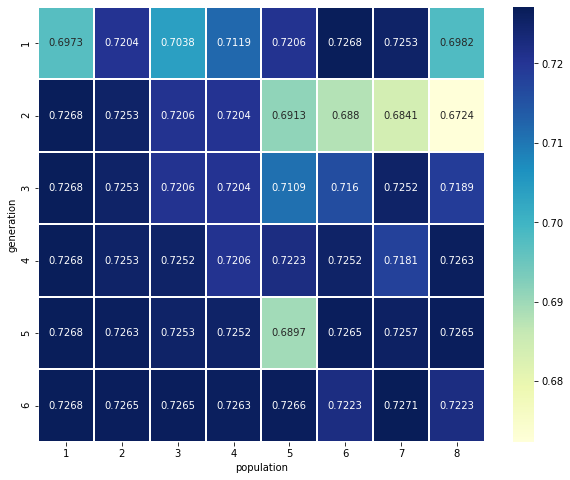

In [20]:
check_crossover(one_point_crossover)

100%|███████████████████████████████████████████| 6/6 [15:36<00:00, 156.14s/it]


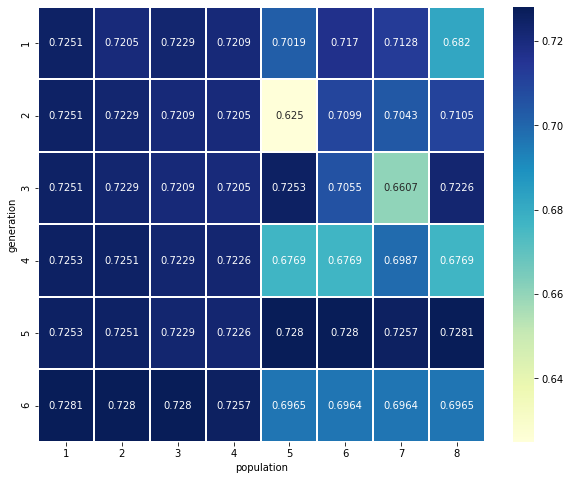

In [21]:
check_crossover(multi_point_crossover)

100%|███████████████████████████████████████████| 6/6 [12:15<00:00, 122.59s/it]


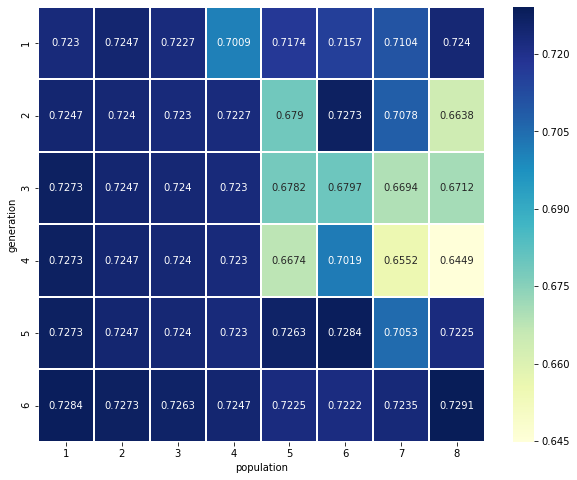

In [22]:
check_crossover(crossover_uniform)